In [45]:
import numpy as np
import pandas as pd
import nltk

import tensorflow as tf


In [5]:
Reviews = pd.read_csv('train_pwd_required/train.csv', sep=",", encoding="utf-8", quotechar='"')

In [6]:
Reviews['CleanReview']=Reviews['ReviewText'].astype(str)
Reviews['CleanReview']=Reviews['CleanReview'].str.replace('[^a-zA-Z\s]','').str.lower()

In [7]:
#function to return words count
def review_words(review_row):
    words = review_row.split()
    return( len(words))


In [8]:
#Store review words count in a separate column
Reviews['WordCount']=Reviews['CleanReview'].apply(lambda x: review_words(x))

In [9]:
##reviews max and min length
print("Minimum-length reviews: {}".format(min(Reviews['WordCount'])))
print("Maximum review length: {}".format(max(Reviews['WordCount'])))

Minimum-length reviews: 0
Maximum review length: 5986


In [10]:
n_steps=100
#keep reviews with non zero max length 100 words 
ReviewsN=Reviews.loc[Reviews['WordCount'] <= n_steps]
ReviewsN=ReviewsN.loc[Reviews['WordCount'] > 0]

In [11]:
print(ReviewsN.groupby('Rating').count())

        ReviewText  CleanReview  WordCount
Rating                                    
1            66247        66331      66331
2            44299        44366      44366
3            79714        79794      79794
4           200354       200600     200600
5           721318       721900     721900


In [49]:
#Random Selection of specific reviews by group
ReviewsNo = 5000  #30000 for scores 1,4,5 and 21000 for score 2 since is less than 30000
Reviews5 = ReviewsN.loc[ReviewsN['Rating'] == 5].sample(ReviewsNo)
Reviews4 = ReviewsN.loc[ReviewsN['Rating'] == 4].sample(ReviewsNo)
Reviews2 = ReviewsN.loc[ReviewsN['Rating'] == 2].sample(5000)
Reviews1 = ReviewsN.loc[ReviewsN['Rating'] == 1].sample(ReviewsNo)

ReviewsF = Reviews1.append([Reviews2, Reviews4, Reviews5])
print(len(ReviewsF))

20000


In [50]:
TotalReviewsNo = 20000
ReviewsF=ReviewsF.sample(TotalReviewsNo)

#Reviews Random group by Score
print(ReviewsF.groupby('Rating').count())

        ReviewText  CleanReview  WordCount
Rating                                    
1             4991         5000       5000
2             4991         5000       5000
4             4995         5000       5000
5             4993         5000       5000


In [51]:
all_text = ' '.join(ReviewsF['CleanReview'])
words = all_text.split()

In [52]:
word_freq = nltk.FreqDist(words)
print ("Found %d unique words tokens." % len(word_freq.items()))

Found 29721 unique words tokens.


In [53]:
from collections import Counter
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [54]:
reviews_ints = []
for each in ReviewsF['CleanReview']:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])

In [55]:
seq_len = n_steps
features = np.zeros((len(reviews_ints), seq_len), dtype=int)

for i, row in enumerate(reviews_ints):
    if len(row)>0: 
        features[i, -len(row):] = np.array(row)[:seq_len]

In [56]:
#print test row
print(len(features))
print(type(features))
print(features[10])
print(len(features[10]))
print(reviews_ints[10])
print(len(reviews_ints[10]))


20000
<class 'numpy.ndarray'>
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0  2346   508 11791
  2347   238     3   104     6  4052   215   513    83    43    14     4
  8756  2400  2575     1    63    17    89     4   900     6 11792  7244
    39  1120     6  5700]
100
[2346, 508, 11791, 2347, 238, 3, 104, 6, 4052, 215, 513, 83, 43, 14, 4, 8756, 2400, 2575, 1, 63, 17, 89, 4, 900, 6, 11792, 7244, 39, 1120, 6, 5700]
31


In [57]:
#Convert score to binary - values 1-2 means negative(0), values 4,5 means positive(1)
ReviewsF['Score_label']=ReviewsF['Rating'].apply(lambda x: 0 if x < 3 else 1)
#labels set as array
labels=np.array(ReviewsF['Score_label'])

In [58]:
split_frac = 0.9

split_index = int(split_frac * len(features))

train_x, val_x = features[:split_index], features[split_index:] 
train_y, val_y = labels[:split_index], labels[split_index:]

split_frac = 0.5
split_index = int(split_frac * len(val_x))

val_x, test_x = val_x[:split_index], val_x[split_index:]
val_y, test_y = val_y[:split_index], val_y[split_index:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))
print("label set: \t\t{}".format(train_y.shape), 
      "\nValidation label set: \t{}".format(val_y.shape),
      "\nTest label set: \t\t{}".format(test_y.shape))

			Feature Shapes:
Train set: 		(18000, 100) 
Validation set: 	(1000, 100) 
Test set: 		(1000, 100)
label set: 		(18000,) 
Validation label set: 	(1000,) 
Test label set: 		(1000,)


In [59]:
lstm_size = 256
lstm_layers = 2
batch_size = 1000
learning_rate = 0.01

In [60]:
n_words = len(vocab_to_int) + 1 # Add 1 for 0 added to vocab

#Create the graph object
tf.reset_default_graph()
with tf.name_scope('inputs'):
    inputs_ = tf.placeholder(tf.int32, [None, None], name="inputs")
    labels_ = tf.placeholder(tf.int32, [None, None], name="labels") #labels_ needs to be two-dimensional to work with some functions later
    keep_prob = tf.placeholder(tf.float32, name="keep_prob") #keep_prob is a scalar (a 0-dimensional tensor), we shouldn't provide a size
    

In [61]:
embed_size = 300 # Size of the embedding vectors (number of units in the embedding layer)

with tf.name_scope("Embeddings"):
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)


In [62]:
def lstm_cell():
    # Our basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size, reuse=tf.get_variable_scope().reuse)
    # Add dropout to the cell
    return tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

with tf.name_scope("RNN_layers"):
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(lstm_layers)])
    
    #[drop] * lstm_layers creates a list of cells (drop) that is lstm_layers long 
    #The MultiRNNCell wrapper builds this into multiple layers of RNN cells, one for each cell in the list
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)   

In [63]:
with tf.name_scope("RNN_forward"):
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)

In [64]:
with tf.name_scope('predictions'):
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
with tf.name_scope('cost'):
    cost = tf.losses.mean_squared_error(labels_, predictions)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


In [65]:
#We add a few nodes to calculate the accuracy which we'll use in the validation pass
with tf.name_scope('validation'):
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [66]:
######Batching######
#This is a simple function for returning batches from our data. 
#First it removes data such that we only have full batches. 
#Then it iterates through the x and y arrays and returns slices out of those arrays with size [batch_size].

def get_batches(x, y, batch_size):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [67]:
###Training and validation in batches
###Once the graph is defined, training can be done in batches based on the batch_size hyper parameter.        

n_epochs = 1
#batches = len(train_x)//batch_size
display_step = 1

In [68]:
# with graph.as_default():
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) #Initialize all variables
    #matrices to store values for charts
    epochs = []  #Iterations
    costs = []  #Loss
    tr_acc = []  #Training Accuracy
    val_acc = [] #Val Accuracy
    b_cost= [] #Training Bach Cost
    b_tr_acc = [] #Training Bach Accuracy
    b_te_acc = [] #Val Bach Accuracy
       

    for e in range(n_epochs):
        state = sess.run(initial_state)
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}

            batch_acc, loss, state, _ = sess.run([accuracy, cost, final_state, optimizer], feed_dict=feed)
            b_tr_acc.append(batch_acc)
            b_cost.append(loss)
            
        if (e+1) % display_step == 0:
        #calculate val acc
            val_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(val_x, val_y, batch_size):
                feed = {inputs_: x,
                        labels_: y[:, None],
                        keep_prob: 1,
                        initial_state: val_state}
                batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                b_te_acc.append(batch_acc)

            print("Epoch: "+str('%04d' % (e+1))+" Cost="+"{:.9f}".format(np.mean(b_cost))+
                  " Train accuracy="+"{:.9f}".format(np.mean(b_tr_acc))+
                  " Val accuracy="+"{:.9f}".format(np.mean(b_te_acc)))
            # add results to matrices at the end of each epoch
            epochs.append(e+1)
            tr_acc.append(np.mean(b_tr_acc))
            val_acc.append(np.mean(b_te_acc))
            costs.append(np.mean(b_cost))
        
        saver.save(sess, './sentiment_model.ckpt')
  
    print("Optimization Finished!")

Epoch: 0001 Cost=0.258546889 Train accuracy=0.594388902 Val accuracy=0.777000010
Optimization Finished!


Populating the interactive namespace from numpy and matplotlib


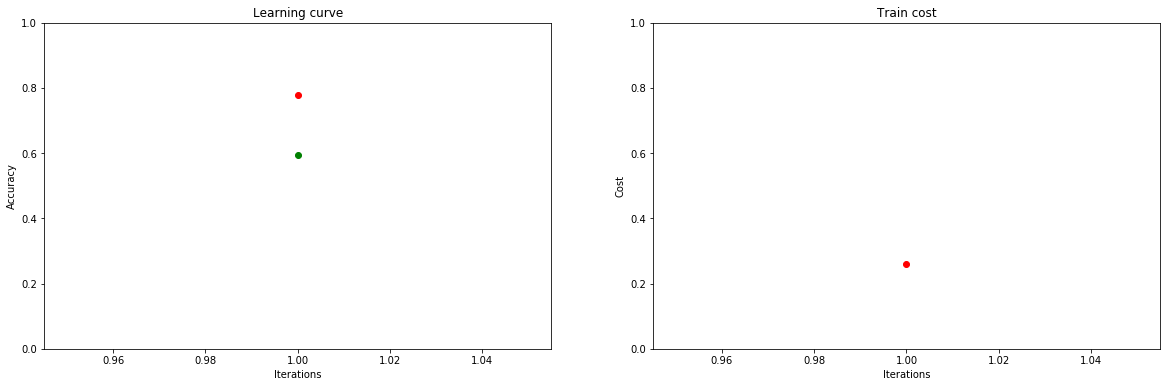

In [69]:
#####################################################################################################
##################### Charts for learning curve and train cost  #####################################
#####################################################################################################

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

fig1 = plt.figure()

ax = fig1.add_subplot(121)
ax.clear()

ax.set_title("Learning curve")
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
ax.plot(epochs, tr_acc,     'o-', color="g", label="Train Accuracy")
ax.plot(epochs, val_acc,   'o-', color="r", label="Test Accuracy")

ax2 = fig1.add_subplot(122)
ax2.clear()

ax2.set_title("Train cost")
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost')
ax2.set_ylim(ymin=0)
ax2.plot(epochs, costs, 'o-', color="r", label="Train cost")

In [70]:
#####################################################################################################
#####################   Testing             #########################################################
#####################################################################################################    
    
test_pred = []
test_acc = []
with tf.Session() as sess:
    saver.restore(sess, './sentiment_model.ckpt')
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        
        prediction = tf.cast(tf.round(predictions),tf.int32)
        prediction = sess.run(prediction,feed_dict=feed)
        test_pred.append(prediction)

INFO:tensorflow:Restoring parameters from ./sentiment_model.ckpt


In [85]:
df_test = pd.read_csv('test1_generic_reviews.csv', sep=",", encoding="utf-8", quotechar='"')
df_test = df_test[~df_test['ReviewText'].isnull()]

In [75]:
%%time
df_validation_set1 = pd.read_csv('test1_generic_reviews.csv', sep=",", encoding="utf-8", quotechar='"', index_col=0)
df_validation_set2 = pd.read_csv('testB_dell_reviews.csv', sep=",", encoding="utf-8", quotechar='"', index_col=0)

Wall time: 431 ms


In [76]:
df_validation_set1['ReviewText'].fillna('', inplace=True)
df_validation_set2['ReviewText'].fillna('', inplace=True)

In [ ]:
predicted1 = clf.predict(X_validation1)
predicted2 = clf.predict(X_validation2)

In [72]:
df_test.head()

,id,ReviewText
0,0,Yesterday I spent over an hour playing with a ...
1,1,I was looking for a light weight cable to go f...
2,2,There appears to be an engineering flaw in the...
3,3,They aren't wide-angle as advertised. They don...
4,4,The angled picture of the ends of this cable m...


In [82]:
#####################################################################################################
#####################   Results             #########################################################
#####################################################################################################    

##############Confusion Matrix######################    
test_pred_flat = (np.array(test_pred)).flatten()
#y_act = pd.Series(test_y, name='ReviewText')
#y_pred = pd.Series(df_test, name='ReviewText')
#df_confusion = pd.crosstab( y_pred, margins=True)

print("Test accuracy: {:.3f}".format(np.mean(test_acc)))  
print("Confusion Matrix")
print("----------------")
#print(df_confusion)
    

Test accuracy: 0.759
Confusion Matrix
----------------


In [91]:
test_pred_flat

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,

In [93]:
##############Review Text for Testing Results######################    
#Take Reviews for test set
start_idx = len(df_test) 
end_idx = start_idx + len(test_pred_flat)
ReviewsTest=df_test.iloc[start_idx:end_idx]
#Add Predicted Sentiment in a new column
ReviewsTest['Predicted_Sentiment']= test_pred_flat

#Examples of False Negative Results
#ReviewsTest[(ReviewsTest['Score_label'] == 1) & (ReviewsTest['Predicted_Sentiment'] == 0 )].iloc[1:10]    
#Examples of False Positive Results
#ReviewsTest[(ReviewsTest['Score_label'] == 0) & (ReviewsTest['Predicted_Sentiment'] == 1 )].iloc[1:10]    


C:\Users\nagorb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [84]:
##############Review Text for Testing Results######################    
#Take Reviews for test set
start_idx = len(df_test) + len(val_x)
end_idx = start_idx + len(test_pred_flat)
ReviewsTest=ReviewsF.iloc[start_idx:end_idx]
#Add Predicted Sentiment in a new column
ReviewsTest['Predicted_Sentiment']= test_pred_flat

#Examples of False Negative Results
ReviewsTest[(ReviewsTest['Score_label'] == 1) & (ReviewsTest['Predicted_Sentiment'] == 0 )].iloc[1:10]    
#Examples of False Positive Results
ReviewsTest[(ReviewsTest['Score_label'] == 0) & (ReviewsTest['Predicted_Sentiment'] == 1 )].iloc[1:10]    


C:\Users\nagorb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,ReviewText,Rating,CleanReview,WordCount,Score_label,Predicted_Sentiment
643867,I ordered these mainly because my wife was com...,1,i ordered these mainly because my wife was com...,84,0,1
1223674,I don't understand if I got the wrong size or ...,2,i dont understand if i got the wrong size or i...,60,0,1
933420,Does not work.,2,does not work,3,0,1
1424735,This item is good if you don't mind it losing ...,2,this item is good if you dont mind it losing a...,74,0,1
999395,I just bought a Compact System Camera and thou...,2,i just bought a compact system camera and thou...,76,0,1
690540,I did not expect that these speakers would be ...,2,i did not expect that these speakers would be ...,65,0,1
58725,"We returned them. They are very heavy, you ca...",2,we returned them they are very heavy you cant...,25,0,1
1050653,I was searching for a laptop power adapter for...,1,i was searching for a laptop power adapter for...,75,0,1
1608126,"The way of operating is not ideal, you need to...",2,the way of operating is not ideal you need to ...,69,0,1
